# Trip Advisor Sentiment Analysis
## Part of project completed for Decision Support Systems course at UofT MIE

In [17]:
# Location is Franz Josef, New Zealand
# Minimal preprocessing required.  There were duplicated rows which had to be dropped
# 28 hotels, average of 213 reviews/hotel and only 8 hotels with <100 reviews The data set was in good condition to start the analysis
# Only NULL values were postal codes which were not required

In [18]:
#Plot
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Data Packages
import math
import pandas as pd
import numpy as np

#Progress bar
from tqdm import tqdm

#Counter
from collections import Counter

#Operation
import operator

#Natural Language Processing Packages
import re
import nltk

## Download Resources
nltk.download("vader_lexicon")
nltk.download("stopwords")
nltk.download("averaged_perceptron_tagger")
nltk.download("wordnet")

from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.tag import PerceptronTagger
from nltk.data import find

## Machine Learning
import sklearn
import sklearn.metrics as metrics

## Data Visualization
import folium
from tabulate import tabulate
from scipy.stats.kde import gaussian_kde

## Geolocation
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [19]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', 500)

# Sentiment Analysis and Aggregation

In [20]:
# Use vader to evaluated sentiment of reviews
def evalSentences(df,cols=['hotelName','reviewCol','vader']):
    sentences = df['reviewColumn'].values
    hotel_review = df[['hotelName','reviewColumn']].itertuples()
    #Instantiate an instance to access SentimentIntensityAnalyzer class
    sid = SentimentIntensityAnalyzer()
    pd_list = []
    for i in hotel_review:
        hotel,sentence = i[1],i[2]
        ss = sid.polarity_scores(sentence)
        pd_list.append((hotel,sentence,ss['compound']))
    reviewDf = pd.DataFrame(pd_list)
    reviewDf.columns = cols
    return reviewDf

In [21]:
columnNames = ['filePath','hotelName','reviewColumn','ratingScore','groundTruth','date_stamp','streetAddress', 'City','Province','postalCode']
hotelDF = pd.read_csv('reviews2.csv',header=None,names=columnNames)

In [22]:
hotelDF.isna().sum()

filePath            0
hotelName           0
reviewColumn        0
ratingScore         0
groundTruth         0
date_stamp          0
streetAddress       0
City                0
Province            0
postalCode       1814
dtype: int64

In [23]:
hotelDF = hotelDF.drop_duplicates().reset_index(drop=True)

In [24]:
# Evaluate Scraped Data
print("Number of hotels: %d" % hotelDF.hotelName.nunique())
print("Number of ratings per hotel: %.2f" % hotelDF.groupby(by='hotelName')['ratingScore'].count().mean())
print("Number of hotels with <100 ratings: %d" %np.sum(hotelDF.groupby(by='hotelName')['ratingScore'].count()<100))
print("Number of reviews: %d" % hotelDF.reviewColumn.nunique())

Number of hotels: 28
Number of ratings per hotel: 213.11
Number of hotels with <100 ratings: 8
Number of reviews: 5967


In [25]:
reviewDF = evalSentences(hotelDF)

In [26]:
# Compute average Vader sentiment and average ground truth rating per hotel.

In [27]:
def avg_rating_per_hotel(df):
  # average the scores over all hotels, you may need to provide additional filtering
  tempDf = df[['hotelName','vader','ratingScore','reviewColumn']]
  tempDf.columns = ['hotelName','AverageVader', 'AverageRatingScore','n_reviews']
  tempDf = tempDf.groupby('hotelName').agg({'AverageVader':'mean', 'AverageRatingScore':'mean','n_reviews':'count'})
  return tempDf

In [28]:
q1a_rating = hotelDF.groupby(by=['hotelName'])['ratingScore'].mean().sort_values(ascending=False)

In [29]:
q1a_vader = reviewDF.groupby(by=['hotelName'])['vader'].mean().sort_values(ascending=False)

In [30]:
# Rank hotels by i) Average Ground Truth Sentiment ii) Average Vader Compound Sentiment Score Show both top-5 and bottom-5 for both ranking methods. 

In [31]:
q1a_rating[:5]

hotelName
Ribbonwood Retreat Bed and Breakfast    4.894118
Holly Homestead B&amp;B                 4.798246
Aspen Court Franz Josef                 4.760000
Glacier Highway Motel                   4.666667
Te Waonui Forest Retreat                4.568627
Name: ratingScore, dtype: float64

In [32]:
q1a_rating[-5:]

hotelName
Franz Josef TOP 10 Holiday Park    3.869436
Kahere Retreat                     3.600000
Chateau Backpackers and Motels     3.244444
Hukawai Lodge                      2.800000
Forest View Franz Josef            2.000000
Name: ratingScore, dtype: float64

In [33]:
q1a_vader[:5]

hotelName
Forest View Franz Josef                 0.994700
Ribbonwood Retreat Bed and Breakfast    0.959482
Holly Homestead B&amp;B                 0.920522
Te Waonui Forest Retreat                0.887034
Aspen Court Franz Josef                 0.885141
Name: vader, dtype: float64

In [34]:
q1a_vader[-5:]

hotelName
Glacier Cottages                        0.732380
Franz Josef TOP 10 Holiday Park         0.680718
Chateau Backpackers and Motels          0.450729
Hukawai Lodge                           0.358020
Central Franz Josef Cabins And Flats    0.277933
Name: vader, dtype: float64

# Frequency Analysis

In [35]:
def get_stop_words():
    stop = set(stopwords.words('english'))
    #Add possible Stop Words for Hotel Reviews
    stop.add('hotel')
    stop.add('room')
    stop.add('rooms')
    stop.add('stay')
    stop.add('staff')
    return stop

def getTopKWords(df, kwords, reviewColumn='reviewColumn'):
    stop = get_stop_words()
    counter = Counter()
    reviews = df[reviewColumn].values
    for review in reviews:
            counter.update([word.lower() 
                            for word 
                            in re.findall(r'\w+', review) 
                            if word.lower() not in stop and len(word) > 2])
    topk = counter.most_common(kwords)
    return topk

In [36]:
# rank the top-50 most frequent non-stopwords for (i) positive reviews and (ii) negative with ground truth sentiment
top50positive = getTopKWords(hotelDF.loc[hotelDF.groundTruth=='positive'],50)
top50negative = getTopKWords(hotelDF.loc[hotelDF.groundTruth=='negative'],50)

In [37]:
top50positive

[('great', 2415),
 ('clean', 2246),
 ('good', 2063),
 ('stayed', 1975),
 ('franz', 1839),
 ('well', 1709),
 ('comfortable', 1624),
 ('one', 1559),
 ('would', 1545),
 ('friendly', 1545),
 ('josef', 1523),
 ('nice', 1520),
 ('place', 1480),
 ('town', 1448),
 ('night', 1332),
 ('helpful', 1300),
 ('glacier', 1283),
 ('motel', 1187),
 ('breakfast', 1054),
 ('really', 1043),
 ('also', 1024),
 ('lovely', 1023),
 ('location', 1023),
 ('area', 981),
 ('recommend', 951),
 ('bed', 948),
 ('nthe', 924),
 ('nights', 911),
 ('free', 889),
 ('bathroom', 886),
 ('small', 861),
 ('two', 857),
 ('walk', 852),
 ('spacious', 840),
 ('kitchen', 830),
 ('everything', 808),
 ('hot', 803),
 ('restaurant', 782),
 ('excellent', 736),
 ('facilities', 716),
 ('large', 710),
 ('restaurants', 700),
 ('could', 695),
 ('new', 650),
 ('day', 645),
 ('service', 629),
 ('little', 620),
 ('quiet', 618),
 ('time', 599),
 ('view', 592)]

In [38]:
top50negative

[('good', 469),
 ('one', 466),
 ('night', 430),
 ('would', 413),
 ('stayed', 401),
 ('clean', 342),
 ('place', 327),
 ('small', 311),
 ('nthe', 280),
 ('bed', 257),
 ('motel', 253),
 ('town', 250),
 ('bathroom', 237),
 ('franz', 236),
 ('could', 230),
 ('nice', 229),
 ('well', 220),
 ('kitchen', 219),
 ('like', 217),
 ('get', 210),
 ('also', 208),
 ('really', 207),
 ('two', 202),
 ('area', 195),
 ('josef', 193),
 ('shower', 188),
 ('breakfast', 186),
 ('location', 184),
 ('people', 183),
 ('glacier', 180),
 ('reception', 179),
 ('great', 174),
 ('nights', 168),
 ('much', 156),
 ('time', 154),
 ('friendly', 151),
 ('booked', 150),
 ('quite', 142),
 ('facilities', 141),
 ('free', 141),
 ('comfortable', 140),
 ('bit', 139),
 ('hot', 139),
 ('around', 139),
 ('however', 139),
 ('even', 138),
 ('day', 136),
 ('restaurant', 136),
 ('wifi', 128),
 ('food', 125)]

In [39]:
# What words appear in both positive and negative reviews?
top50intersection = set([x[0] for x in top50positive]).intersection(set([x[0] for x in top50negative]))

In [40]:
top50intersection

{'also',
 'area',
 'bathroom',
 'bed',
 'breakfast',
 'clean',
 'comfortable',
 'could',
 'day',
 'facilities',
 'franz',
 'free',
 'friendly',
 'glacier',
 'good',
 'great',
 'hot',
 'josef',
 'kitchen',
 'location',
 'motel',
 'nice',
 'night',
 'nights',
 'nthe',
 'one',
 'place',
 'really',
 'restaurant',
 'small',
 'stayed',
 'time',
 'town',
 'two',
 'well',
 'would'}

In [41]:
# Repeat this analysis for the top-50 noun phrases 

In [42]:
# to make the results more useable, we clean up the tree results shown above. 
lemmatizer = nltk.WordNetLemmatizer()
stemmer = nltk.stem.porter.PorterStemmer()
stopword_list = get_stop_words()

# generator, create item one a time
def get_terms(tree):
    for leaf in leaves(tree):
        term = [normalise(w) for w,t in leaf if acceptable_word(w)]
        # Phrase only
        if len(term)>1:
            yield term

def get_tuple_terms(tree):
    for leaf in leaves(tree):
        term_tuple = tuple(x for x in [normalise(w) for w,t in leaf if acceptable_word(w)])
        # Phrase only
        if len(term_tuple)>1:
            yield term_tuple

# generator, generate leaves one by one
def leaves(tree):
    """Finds NP (nounphrase) leaf nodes of a chunk tree."""
    for subtree in tree.subtrees(filter = lambda t: t.label()=='NP' or t.label()=='JJ' or t.label()=='RB'):
        yield subtree.leaves()

# stemming, lematizing, lower case... 
def normalise(word,lemmatizer=lemmatizer, stemmer=stemmer):
    """Normalises words to lowercase and stems and lemmatizes it."""
    word = word.lower()
    word = stemmer.stem(word)
    word = lemmatizer.lemmatize(word)
    return word

# stop-words and length control
def acceptable_word(word, stopword_list=stopword_list):
    """Checks conditions for acceptable word: length, stopword."""
    accepted = bool(2 <= len(word) <= 40
        and word.lower() not in stopword_list)
    return accepted

# Flatten phrase lists to get tokens for analysis
def flatten_phrase_lists(npTokenList):
    finalList =[]
    for phrase in npTokenList:
        token = ''
        for word in phrase:
            token += word + ' '
        finalList.append(token.rstrip())
    return finalList

grammar = r"""
    NBAR:
        {<NN.*|JJ>*<NN.*>}  # Nouns and Adjectives, terminated with Nouns
        
    NP:
        {<NBAR>}
        {<NBAR><IN><NBAR>}  # Above, connected with in/of/etc...
"""

def getTopKNP(df, k, grammar=grammar, reviewColumn='reviewColumn'):
    counter = Counter()
    lemmatizer = nltk.WordNetLemmatizer()
    stemmer = nltk.stem.porter.PorterStemmer()
    tagger = PerceptronTagger()
    pos_tag = tagger.tag
    chunker = nltk.RegexpParser(grammar)
    reviews = df[reviewColumn].values
    for review in tqdm(reviews):
        taggedToks = pos_tag(re.findall(r'\w+', review))
        tree = chunker.parse(taggedToks)
        npTokenList = counter.update([word for word in get_tuple_terms(tree)])
    topk = counter.most_common(k)
    return topk

In [43]:
# rank the top-50 most frequent noun phrases
top50positiveNP = getTopKNP(hotelDF.loc[hotelDF.groundTruth=='positive'],50)
top50negativeNP = getTopKNP(hotelDF.loc[hotelDF.groundTruth=='negative'],50)

100%|██████████| 899/899 [00:06<00:00, 138.68it/s]


In [44]:
top50intersectionNP = set([x[0] for x in top50positiveNP]).intersection(set([x[0] for x in top50negativeNP]))

In [45]:
top50positiveNP

[(('franz', 'josef'), 880),
 (('new', 'zealand'), 230),
 (('hot', 'pool'), 177),
 (('franz', 'joseph'), 143),
 (('great', 'place'), 123),
 (('rainforest', 'retreat'), 117),
 (('franz', 'josef', 'glacier'), 113),
 (('short', 'walk'), 111),
 (('main', 'road'), 107),
 (('main', 'street'), 106),
 (('south', 'island'), 105),
 (('comfort', 'bed'), 103),
 (('great', 'locat'), 100),
 (('aspen', 'court'), 90),
 (('free', 'wifi'), 87),
 (('small', 'town'), 86),
 (('great', 'view'), 84),
 (('hot', 'tub'), 84),
 (('front', 'desk'), 77),
 (('minut', 'walk'), 75),
 (('te', 'waonui'), 74),
 (('good', 'valu'), 73),
 (('spa', 'bath'), 70),
 (('fox', 'glacier'), 68),
 (('short', 'drive'), 67),
 (('west', 'coast'), 64),
 (('long', 'drive'), 59),
 (('good', 'locat'), 58),
 (('good', 'size'), 54),
 (('heli', 'hike'), 53),
 (('bedroom', 'apart'), 52),
 (('warm', 'welcom'), 50),
 (('bedroom', 'unit'), 48),
 (('great', 'valu'), 45),
 (('town', 'centr'), 44),
 (('nice', 'place'), 44),
 (('next', 'morn'), 44),


In [46]:
top50negativeNP

[(('franz', 'josef'), 108),
 (('new', 'zealand'), 55),
 (('rainforest', 'retreat'), 26),
 (('franz', 'joseph'), 25),
 (('south', 'island'), 23),
 (('hot', 'water'), 21),
 (('good', 'locat'), 21),
 (('good', 'valu'), 19),
 (('hot', 'pool'), 19),
 (('singl', 'bed'), 18),
 (('second', 'night'), 18),
 (('franz', 'josef', 'glacier'), 17),
 (('free', 'wifi'), 16),
 (('hot', 'tub'), 16),
 (('main', 'road'), 15),
 (('front', 'desk'), 14),
 (('short', 'walk'), 14),
 (('small', 'town'), 14),
 (('holiday', 'park'), 13),
 (('next', 'day'), 13),
 (('first', 'night'), 13),
 (('tree', 'lodg'), 13),
 (('travel', 'agent'), 12),
 (('fox', 'glacier'), 12),
 (('next', 'morn'), 12),
 (('queen', 'bed'), 11),
 (('power', 'site'), 11),
 (('good', 'size'), 11),
 (('car', 'park'), 10),
 (('park', 'lot'), 10),
 (('bunk', 'bed'), 9),
 (('minut', 'walk'), 9),
 (('doubl', 'bed'), 9),
 (('good', 'thing'), 9),
 (('recept', 'area'), 9),
 (('ground', 'floor'), 9),
 (('tour', 'group'), 9),
 (('continent', 'breakfast'), 

In [47]:
# Do any noun phrases appear in both positive and negative reviews?
top50intersectionNP

{('doubl', 'bed'),
 ('fox', 'glacier'),
 ('franz', 'josef'),
 ('franz', 'josef', 'glacier'),
 ('franz', 'joseph'),
 ('free', 'wifi'),
 ('front', 'desk'),
 ('good', 'locat'),
 ('good', 'size'),
 ('good', 'valu'),
 ('ground', 'floor'),
 ('hot', 'pool'),
 ('hot', 'tub'),
 ('main', 'road'),
 ('minut', 'walk'),
 ('new', 'zealand'),
 ('next', 'day'),
 ('next', 'morn'),
 ('rainforest', 'retreat'),
 ('short', 'drive'),
 ('short', 'walk'),
 ('small', 'town'),
 ('south', 'island'),
 ('tree', 'lodg'),
 ('west', 'coast')}

In [48]:
# Identify a noun phrase you did not expect to see in the positive reviews and explain why it may be there.
print("""None of these were a huge surprise for positive reviews.  'long, drive' and 'long', 'day' are less positive, but more likely indicators of the towns remote location than anything else.
Some phrases such as 'front desk' I would associate with negative reviews a little more.  This was in-fact mentioned during lecture as a word ('front') which may have negative associations.
For example poor experiences with the front desk.  It could just as easily be referencing positive experiences which the front desk though.
""")

None of these were a huge surprise for positive reviews.  'long, drive' and 'long', 'day' are less positive, but more likely indicators of the towns remote location than anything else.
Some phrases such as 'front desk' I would associate with negative reviews a little more.  This was in-fact mentioned during lecture as a word ('front') which may have negative associations.
For example poor experiences with the front desk.  It could just as easily be referencing positive experiences which the front desk though.



In [49]:
# Repeat this analysis again for the top-50 noun phrases using a refined grammar pattern

In [50]:
# to avoid redefining functions we will continue to refer to these as 'NP'
#grammar_2c = r"""
#    NBAR:
#        {<JJ.*|VBD.*|NN.*>*<RB.*|JJ.*>}  # Nouns and Adjectives and Verbs, terminated with Adverbs and Adjectives
#    NP:
#        {<NBAR>}  # Above
#"""

In [51]:
grammar_2c = r"""
    P1:
        {<JJ.*>*<NN.*>}  # Adjective terminated with Noun
    P2:
        {<VB.*|RB.*>*<RB.*|JJ.*>}
    NP:
        {<P1>}  # Above
        {<P2>}
"""

In [52]:
# is clean: VB JJ
# are rather new: VBP RB JJ
# the owner friendly: DT NN RB
# really nice cosy: RB JJ JJ
# lovely furnishing: RB VBG
# lovely view: JJ NN
# good place: JJ NN
# come back: VB RB
# stay here again: VB RB RB

In [53]:
top50positiveNP2c = getTopKNP(hotelDF.loc[hotelDF.groundTruth=='positive'],50,grammar=grammar_2c)
top50negativeNP2c = getTopKNP(hotelDF.loc[hotelDF.groundTruth=='negative'],50,grammar=grammar_2c)
top50intersectionNP2c = set([x[0] for x in top50positiveNP2c]).intersection(set([x[0] for x in top50negativeNP2c]))

100%|██████████| 899/899 [00:07<00:00, 125.68it/s]


In [54]:
top50positiveNP2c[:]

[(('hot', 'pool'), 208),
 (('comfort', 'bed'), 176),
 (('great', 'place'), 139),
 (('free', 'wifi'), 128),
 (('main', 'road'), 121),
 (('short', 'walk'), 119),
 (('main', 'street'), 109),
 (('hot', 'tub'), 106),
 (('great', 'locat'), 98),
 (('great', 'view'), 97),
 (('small', 'town'), 95),
 (('good', 'valu'), 92),
 (('next', 'door'), 92),
 (('come', 'back'), 85),
 (('good', 'size'), 79),
 (('spa', 'bath'), 75),
 (('short', 'drive'), 73),
 (('good', 'locat'), 73),
 (('nice', 'touch'), 65),
 (('long', 'drive'), 64),
 (('warm', 'welcom'), 60),
 (('nice', 'place'), 59),
 (('best', 'place'), 58),
 (('next', 'day'), 56),
 (('stay', 'longer'), 55),
 (('free', 'breakfast'), 55),
 (('local', 'restaur'), 54),
 (('next', 'morn'), 53),
 (('singl', 'bed'), 52),
 (('free', 'soup'), 52),
 (('great', 'valu'), 50),
 (('electr', 'blanket'), 49),
 (('good', 'place'), 47),
 (('high', 'standard'), 47),
 (('spotlessli', 'clean'), 46),
 (('beauti', 'view'), 45),
 (('make', 'sure'), 45),
 (('long', 'day'), 45

In [55]:
top50negativeNP2c

[(('good', 'locat'), 26),
 (('hot', 'water'), 24),
 (('free', 'wifi'), 20),
 (('good', 'valu'), 20),
 (('hot', 'pool'), 19),
 (('hot', 'tub'), 19),
 (('second', 'night'), 19),
 (('singl', 'bed'), 18),
 (('work', 'well'), 18),
 (('next', 'door'), 18),
 (('main', 'road'), 17),
 (('next', 'day'), 16),
 (('short', 'walk'), 15),
 (('good', 'size'), 15),
 (('small', 'town'), 14),
 (('next', 'morn'), 14),
 (('first', 'night'), 13),
 (('queen', 'bed'), 12),
 (('go', 'back'), 12),
 (('comfort', 'bed'), 11),
 (('continent', 'breakfast'), 11),
 (('en', 'suit'), 10),
 (('doubl', 'bed'), 10),
 (('come', 'back'), 10),
 (('nthe', 'kitchen'), 10),
 (('hot', 'plate'), 9),
 (('arriv', 'late'), 9),
 (('short', 'drive'), 9),
 (('power', 'site'), 9),
 (('look', 'forward'), 9),
 (('good', 'thing'), 9),
 (('free', 'soup'), 9),
 (('common', 'area'), 9),
 (('expect', 'much'), 9),
 (('good', 'view'), 8),
 (('nice', 'place'), 8),
 (('commun', 'kitchen'), 8),
 (('good', 'night'), 8),
 (('last', 'night'), 8),
 (('

In [56]:
top50intersectionNP2c

{('arriv', 'late'),
 ('come', 'back'),
 ('comfort', 'bed'),
 ('doubl', 'bed'),
 ('free', 'breakfast'),
 ('free', 'soup'),
 ('free', 'wifi'),
 ('go', 'back'),
 ('good', 'locat'),
 ('good', 'size'),
 ('good', 'valu'),
 ('hot', 'pool'),
 ('hot', 'tub'),
 ('long', 'drive'),
 ('main', 'road'),
 ('next', 'day'),
 ('next', 'door'),
 ('next', 'morn'),
 ('nice', 'place'),
 ('nice', 'touch'),
 ('short', 'drive'),
 ('short', 'walk'),
 ('singl', 'bed'),
 ('small', 'town')}

In [57]:
print("""
the new pattern is more effective for sentiment analysis. For several reasons:
1. We change {<NN.*|JJ>*<NN.*>} to {<JJ.*>*<NN.*>}.  
- This is significant for cutting down on location specific terms such as 'Franz Josef' which are nouns terminated with nouns
- Noun heavy phrases are less descriptive and more location specific.  We want to focus on descriptions of nouns

2. We add {<VB.*|RB.*>*<RB.*|JJ.*>}
- The original grammar completely ignored verbs and adverbs which contain tons of descriptive words indicative of sentiment
- Certain phrases were selected from the reviews which I considered good indicators of sentiment
- These phrases and their corresponding POS tags include:

# is clean: VB JJ
# are rather new: VBP RB JJ
# the owner friendly: DT NN RB
# really nice cosy: RB JJ JJ
# lovely furnishing: RB VBG
# lovely view: JJ NN
# good place: JJ NN
# come back: VB RB
# stay here again: VB RB RB

- We can notice lots of adverb and verb combinations here.  The second grammar rule we included is capable of picking up every phrase I identified as significant

3. We cut down on longer phrases by removing {<NBAR><IN><NBAR>}
- if our phrases are too complex and long the phrase counts across reviews will be very small
- we still require high phrase counts across reviews for effective analysis

For these reasons I consider the new grammar more effective for sentiment analysis
""")


the new pattern is more effective for sentiment analysis. For several reasons:
1. We change {<NN.*|JJ>*<NN.*>} to {<JJ.*>*<NN.*>}.  
- This is significant for cutting down on location specific terms such as 'Franz Josef' which are nouns terminated with nouns
- Noun heavy phrases are less descriptive and more location specific.  We want to focus on descriptions of nouns

2. We add {<VB.*|RB.*>*<RB.*|JJ.*>}
- The original grammar completely ignored verbs and adverbs which contain tons of descriptive words indicative of sentiment
- Certain phrases were selected from the reviews which I considered good indicators of sentiment
- These phrases and their corresponding POS tags include:

# is clean: VB JJ
# are rather new: VBP RB JJ
# the owner friendly: DT NN RB
# really nice cosy: RB JJ JJ
# lovely furnishing: RB VBG
# lovely view: JJ NN
# good place: JJ NN
# come back: VB RB
# stay here again: VB RB RB

- We can notice lots of adverb and verb combinations here.  The second grammar rule we 

# Mutual Information

In [58]:
def dataFrameTransformation(hotelDf, reviewDF, topk, reviewColumn='reviewCol'):
    reviews = reviewDF[reviewColumn].values
    
    #Find out if a particular review has the word from topk list
    freqReview = []
    for i in range(len(reviews)):
        tempCounter = Counter([word.lower() for word in re.findall(r'\w+',reviews[i])])
        topkinReview = [1 if tempCounter[word] > 0 else 0 for (word,wordCount) in topk]
        freqReview.append(topkinReview)
        
        
    #Prepare freqReviewDf
    freqReviewDf = pd.DataFrame(freqReview)
    dfName = []
    for c in topk:
        dfName.append(c[0])
    freqReviewDf.columns = dfName
    finalreviewDf = reviewDF.join(freqReviewDf)
    finaldf = hotelDf[['hotelName','ratingScore','groundTruth']].join(finalreviewDf.drop('hotelName',axis=1))
    return finaldf


In [59]:
topk = getTopKWords(reviewDF, 500, reviewColumn='reviewCol')
finaldf = dataFrameTransformation(hotelDF, reviewDF, topk)

In [60]:
# get Top K mutual information terms from the dataframe
def getMI(topk, df, label_column='groundTruth'):
    miScore = []
    for word in topk:
        miScore.append([word[0]]+[metrics.mutual_info_score(df[label_column], df[word[0]])])
    miScoredf = pd.DataFrame(miScore).sort_values(1,ascending=0)
    miScoredf.columns = ['Word','MI Score']
    return miScoredf

In [61]:
# Use mutual information (MI) with ground truth sentiment to rank the top-50 most sentiment-bearing non-stopwords in the review collection.

In [62]:
miScoredf = getMI(topk, finaldf)

In [63]:
# Which words get the highest MI values? Does this make sense?
miScoredf.head(50)

,Word,MI Score
0,great,0.012601
96,people,0.010834
90,highly,0.009818
253,expensive,0.009815
231,basic,0.009735
45,excellent,0.009673
451,poor,0.009656
9,comfortable,0.009049
484,average,0.008236
337,old,0.007405


In [64]:
# Repeat this analysis for the top-50 noun phrases

In [65]:
def dataFrameTransformationNP(hotelDf, reviewDF, topk, grammar=grammar):
    counter = Counter()
    lemmatizer = nltk.WordNetLemmatizer()
    stemmer = nltk.stem.porter.PorterStemmer()
    tagger = PerceptronTagger()
    pos_tag = tagger.tag
    chunker = nltk.RegexpParser(grammar)
    reviews = reviewDF['reviewCol'].values
    
    #Find out if a particular review has the word from topk list
    freqReview = []
    for i in range(len(reviews)):
        taggedToks = pos_tag(re.findall(r'\w+', reviews[i]))
        tree = chunker.parse(taggedToks)
        tempCounter = Counter([phrase for phrase in get_tuple_terms(tree)])
        topkinReview = [1 if tempCounter[phrase] > 0 else 0 for (phrase,phraseCount) in topk]
        freqReview.append(topkinReview)
           
    #Prepare freqReviewDf
    freqReviewDf = pd.DataFrame(freqReview)
    dfName = []
    for c in topk:
        dfName.append(c[0])
    freqReviewDf.columns = dfName
    finalreviewDf = reviewDF.join(freqReviewDf)
    finaldf = hotelDf[['hotelName','ratingScore','groundTruth']].join(finalreviewDf.drop('hotelName',axis=1))
    return finaldf

In [66]:
topKNP = getTopKNP(reviewDF, 500, grammar=grammar_2c, reviewColumn='reviewCol')

100%|██████████| 5967/5967 [00:42<00:00, 140.79it/s]


In [67]:
finaldfNP = dataFrameTransformationNP(hotelDF,reviewDF,topKNP,grammar=grammar_2c)

In [68]:
miScoredfNP = getMI(topKNP, finaldfNP)

In [69]:
# Which noun phrases get the highest MI values?
miScoredfNP.head(50)

,Word,MI Score
3,"(great, place)",0.002332
469,"(cold, water)",0.001746
31,"(stay, longer)",0.001513
416,"(young, backpack)",0.001480
12,"(great, locat)",0.001387
26,"(hot, water)",0.001377
213,"(expect, much)",0.001332
1,"(comfort, bed)",0.001328
46,"(beauti, view)",0.001237
47,"(extrem, help)",0.001209


In [70]:
print(""" A couple phrases stood out.  
- 'cold, water'
- 'hot, water'
- 'young, backpack'

It sounds like the hotels should invest in bigger water heaters! Small towns in New Zealand often rely on small water tanks for heating and it is not uncommon to run out of hot water in the showers.  
Hotels could also do a better job separating backpackers from other guests if possible.
""")

 A couple phrases stood out.  
- 'cold, water'
- 'hot, water'
- 'young, backpack'

It sounds like the hotels should invest in bigger water heaters! Small towns in New Zealand often rely on small water tanks for heating and it is not uncommon to run out of hot water in the showers.  
Hotels could also do a better job separating backpackers from other guests if possible.



# Pointwise Mutual Information

In [71]:
# Compute \for all terms and all possible labels
def pmiForAllCal(df, topk_word, gt_sentiment, label_column='groundTruth'):
    #Try calculate all the pmi for top k and store them into one pmidf dataframe
    
    index = [x[0] for x in topk_word]
    pmiDf = pd.DataFrame(index=index, columns=['pmi'])

    for (word, count) in tqdm(topk_word):
        pmiDf.at[word, 'pmi'] = pmiCalc(df,word,gt_sentiment,label_column)
    
    return pmiDf


def pmiCalc(df, word, gt_sentiment, label_column='groundTruth'):
    
    N = df.shape[0]
    
    px = sum(df[label_column]==gt_sentiment)
    py = sum(df[word]==True)
    pxy = len(df[(df[label_column]==gt_sentiment) & (df[word]==True)])

    if pxy==0:#Log 0 cannot happen
        pmi = math.log((pxy+0.0001)*N/(px*py))
    else:
        pmi = math.log(pxy*N/(px*py))
    return pmi

In [72]:
# calculate the top-50 words according to Pointwise Mutual In-formation (PMI) of the word occurring with 
# (i) positive reviews and (ii) negative reviews.

In [73]:
pmiposdf = pmiForAllCal(finaldf,topk,'positive')
pminegdf = pmiForAllCal(finaldf,topk,'negative')

100%|██████████| 500/500 [00:01<00:00, 273.50it/s]


In [74]:
pmiposdf.sort_values(by='pmi',ascending=False).head(50)

,pmi
thanks,0.151393
bernie,0.151177
highly,0.150559
delicious,0.146677
julie,0.144949
cozy,0.144067
peaceful,0.143495
ribbonwood,0.141792
attractions,0.139768
loved,0.135623


In [75]:
pminegdf.sort_values(by='pmi',ascending=False).head(50)

,pmi
poor,1.37877
average,1.32586
paid,1.16972
work,1.16926
old,1.15009
expensive,1.13201
said,1.12862
basic,1.127
backpackers,1.11458
noisy,1.06708


In [76]:
# Repeat this analysis for the top-50 noun phrases using grammar 

In [77]:
pmiposdfNP = pmiForAllCal(finaldfNP,topKNP,'positive')
pminegdfNP = pmiForAllCal(finaldfNP,topKNP,'negative')

100%|██████████| 500/500 [00:01<00:00, 308.14it/s]


In [78]:
pmiposdfNP.sort_values(by='pmi',ascending=False).head(50)

,pmi
"(great, host)",0.163298
"(spaciou, clean)",0.163298
"(comfort, motel)",0.163298
"(friendli, owner)",0.163298
"(comfort, accommod)",0.163298
"(local, area)",0.163298
"(good, cook)",0.163298
"(great, base)",0.163298
"(main, hous)",0.163298
"(super, help)",0.163298


In [79]:
pminegdfNP.sort_values(by='pmi',ascending=False).head(50)

,pmi
"(cold, water)",1.75919
"(young, backpack)",1.6414
"(better, valu)",1.48725
"(expect, much)",1.38189
"(pay, extra)",1.3331
"(open, plan)",1.30493
"(shower, head)",1.28658
"(came, back)",1.27368
"(commun, area)",1.26411
"(top, ten)",1.19957


In [80]:
# Repeat this analysis for the single top and single bottom hotel (according to the ground truth rating)

In [81]:
top_ranked = q1a_rating[:1].index[0]

In [82]:
# bottom rank has 1 review, taked 2nd lowest ranked (which has 5 ratings)
bottom_ranked = q1a_rating[-2:-1].index[0]

In [83]:
def single_hotel(hotel,hotelDF,reviewDF,k):
    reviewDF1 = reviewDF.loc[reviewDF.hotelName==hotel].copy()
    hotelDF1 = hotelDF.loc[hotelDF.hotelName==hotel].copy()
    topk = getTopKWords(reviewDF1, k, reviewColumn='reviewCol')
    finaldf = dataFrameTransformation(hotelDF,reviewDF,topk)
    finaldf = finaldf.loc[finaldf.hotelName==hotel].copy()
    pmiposdf = pmiForAllCal(finaldf,topk,'positive')
    pminegdf = pmiForAllCal(finaldf,topk,'negative')
    return pmiposdf, pminegdf

In [84]:
pmipos_top, pmineg_top = single_hotel(top_ranked,hotelDF,reviewDF,500)

100%|██████████| 500/500 [00:00<00:00, 806.08it/s]


In [85]:
pmipos_bottom, pmineg_bottom = single_hotel(bottom_ranked,hotelDF,reviewDF,500)

100%|██████████| 300/300 [00:00<00:00, 850.06it/s]


In [86]:
pmipos_top.sort_values(by='pmi',ascending=False).head(50)

,pmi
pleasant,0.0178046
upon,0.0178046
across,0.0178046
nit,0.0178046
fine,0.0178046
bath,0.0178046
whole,0.0178046
read,0.0178046
front,0.0178046
base,0.0178046


In [87]:
pmineg_top.sort_values(by='pmi',ascending=False).head(50)

,pmi
price,3.34404
season,2.93857
instead,2.93857
however,2.93857
tourist,2.93857
wing,2.65089
left,2.65089
forward,2.65089
policy,2.65089
reservation,2.65089


In [88]:
pmipos_bottom.sort_values(by='pmi',ascending=False).head(50)

,pmi
everyone,0.916291
aways,0.916291
find,0.916291
signs,0.916291
pointing,0.916291
right,0.916291
direction,0.916291
set,0.916291
quite,0.916291
see,0.916291


In [89]:
pmineg_bottom.sort_values(by='pmi',ascending=False).head(50)

,pmi
support,0.510826
place,0.510826
sometimes,0.510826
websites,0.510826
reservation,0.510826
made,0.510826
conveniently,0.510826
closed,0.510826
recommend,0.510826
expected,0.510826


In [90]:
print("""
We can make inferences from the positive and negative words.  These inferences paint a picture of the experience at the hotel and what stands out.  
The exception was the negative words for the bottom ranked location were not very useful.

Top Ranked:
Inference from Positive Words:
- informative, knowledgable and pleasant staff
- breakfast with pancakes and fruits
- upgraded rooms
Inference from Negative Words:
- Expensive
- Busy tourist season
- Inflated reviews

Bottom Ranked:
Inference from Positive Words:
- Inviting and warm
- Robyn is a positive staff member
- Smaller boutique location
Inference from Negative Words:
- Issues with reservations on the website
- Backpackers at the hotel
""")


We can make inferences from the positive and negative words.  These inferences paint a picture of the experience at the hotel and what stands out.  
The exception was the negative words for the bottom ranked location were not very useful.

Top Ranked:
Inference from Positive Words:
- informative, knowledgable and pleasant staff
- breakfast with pancakes and fruits
- upgraded rooms
Inference from Negative Words:
- Expensive
- Busy tourist season
- Inflated reviews

Bottom Ranked:
Inference from Positive Words:
- Inviting and warm
- Robyn is a positive staff member
- Smaller boutique location
Inference from Negative Words:
- Issues with reservations on the website
- Backpackers at the hotel



# Visualization


In [91]:
# Show separate histograms of ground truth and Vader sentiment scores 
def getHistogram(df, measure, title,figsize=(10,5)):
    fig = plt.figure(figsize=figsize)
    plt.title(title)
    
    if measure=='both':
        x = [df['ratingScore'].values/5]
        y = [df['vader'].values]
        bins = np.linspace(-1, 1, 100)
        plt.hist(x, bins, label='normalized Ground Truth')
        plt.hist(y, bins, label='vader')
        plt.legend(loc='upper right')
        plt.xlabel("Value")
        plt.ylabel("Frequency")
    else:
        plt.hist(df[measure].values)

    plt.xlabel("Value")
    plt.ylabel("Frequency")

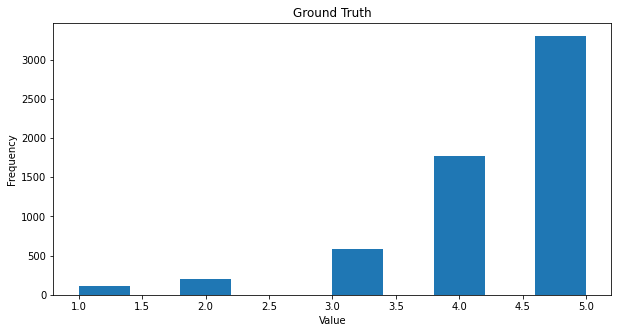

In [92]:
getHistogram(finaldf,'ratingScore', 'Ground Truth')

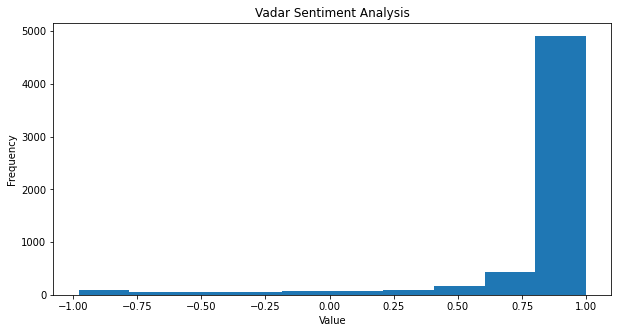

In [93]:
getHistogram(finaldf, 'vader', 'Vadar Sentiment Analysis')

In [94]:
#finaldf.loc[(finaldf.groundTruth=='negative')].sort_values(by='ratingScore',ascending=False)

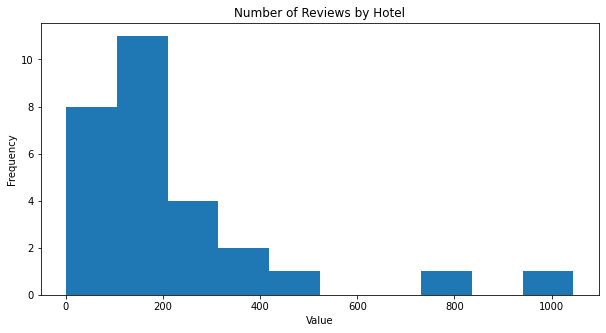

In [95]:
# Show a histogram of the number of reviews per hotel. 
getHistogram(hotelDF.groupby(by='hotelName')[['ratingScore']].count().reset_index(),'ratingScore','Number of Reviews by Hotel')

In [96]:
print("""
Most hotels are in the 0 - 200 review range with a steep fall-off after that.  Roughly half the hotels have 100-200 reviews.
""")


Most hotels are in the 0 - 200 review range with a steep fall-off after that.  Roughly half the hotels have 100-200 reviews.



In [97]:
# Show a plot of side-by-side boxplots for the top-5 ranked hotels according to star rating

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


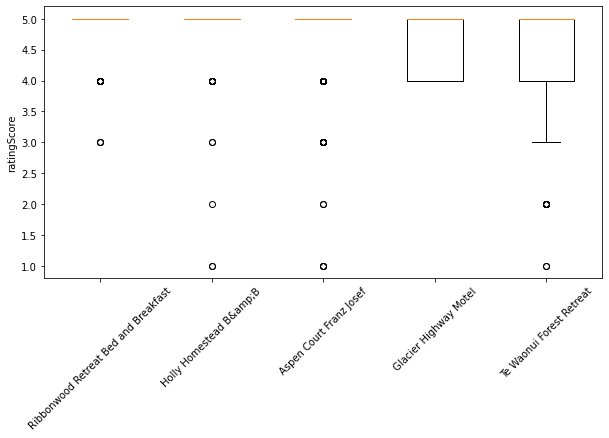

In [98]:
hotel_list = []
for hotel in list(q1a_rating[:5].index):
  _hotel = finaldf.loc[finaldf['hotelName'] == hotel]['ratingScore']
  hotel_list.append(_hotel)
plt.figure(figsize=(10,5))
plt.boxplot(hotel_list)
plt.xticks(np.arange(1,6), q1a_rating[:5].index,rotation=45)
plt.ylabel('ratingScore')
plt.show()

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


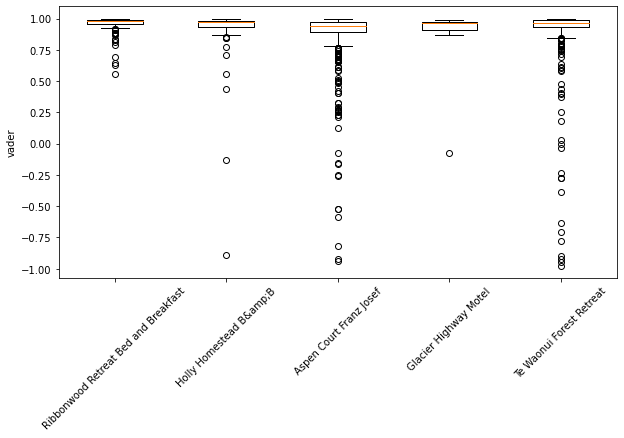

In [99]:
hotel_list = []
for hotel in list(q1a_rating[:5].index):
  _hotel = finaldf.loc[finaldf['hotelName'] == hotel]['vader']
  hotel_list.append(_hotel)
plt.figure(figsize=(10,5))
plt.boxplot(hotel_list)
plt.xticks(np.arange(1,6), q1a_rating[:5].index,rotation=45)
plt.ylabel('vader')
plt.show()

In [100]:
# Report the mean and variance of the ground truth and Vader sentiment scores for the top-5 ranked hotels according to star rating

In [101]:
stats_top5_groundtruth = {}
for hotel in list(q1a_rating[:5].index):
  stats_top5_groundtruth[hotel] = tuple((finaldf.loc[finaldf['hotelName'] == hotel]['ratingScore'].mean(),finaldf.loc[finaldf['hotelName'] == hotel]['ratingScore'].var()))

stats_top5_vader = {}
for hotel in list(q1a_rating[:5].index):
  stats_top5_vader[hotel] = tuple((finaldf.loc[finaldf['hotelName'] == hotel]['vader'].mean(),finaldf.loc[finaldf['hotelName'] == hotel]['vader'].var()))


In [102]:
pd.DataFrame.from_dict(stats_top5_groundtruth,orient='index',columns=['mean','variance'])

,mean,variance
Ribbonwood Retreat Bed and Breakfast,4.894118,0.130734
Holly Homestead B&amp;B,4.798246,0.463360
Aspen Court Franz Josef,4.760000,0.306667
Glacier Highway Motel,4.666667,0.238095
Te Waonui Forest Retreat,4.568627,0.575131


In [103]:
pd.DataFrame.from_dict(stats_top5_vader,orient='index',columns=['mean','variance'])

,mean,variance
Ribbonwood Retreat Bed and Breakfast,0.959482,0.003888
Holly Homestead B&amp;B,0.920522,0.045302
Aspen Court Franz Josef,0.885141,0.043503
Glacier Highway Motel,0.878860,0.071457
Te Waonui Forest Retreat,0.887034,0.083535


In [104]:
# Show both a scatterplot and heatmap of ground truth score (star rating) versus Vader sentiment score. 

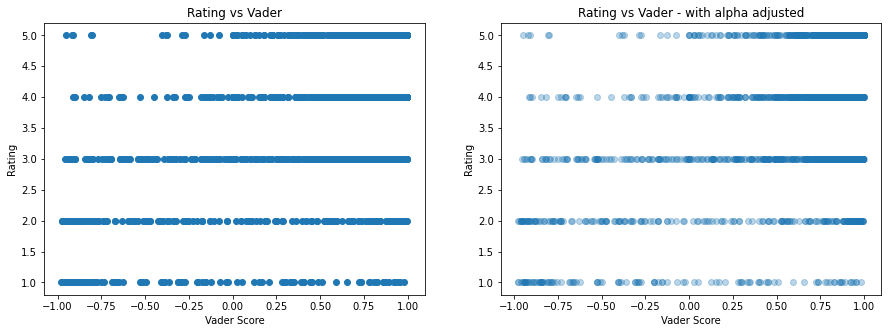

In [105]:
fig, ax = plt.subplots(1,2,figsize=(15,5),sharex=False,sharey=False)
rating_scores = finaldf['ratingScore'].values
vader_scores = finaldf['vader'].values
ax[0].plot(vader_scores, rating_scores,"o")
ax[1].plot(vader_scores, rating_scores,"o", alpha=0.3)

ax[0].set_title('Rating vs Vader')
ax[1].set_title('Rating vs Vader - with alpha adjusted')

for _ax in ax:
  _ax.set_ylabel('Rating')
  _ax.set_xlabel('Vader Score')

In [106]:
k = gaussian_kde(np.vstack([vader_scores, rating_scores]))
xi, yi = np.mgrid[vader_scores.min():vader_scores.max():vader_scores.size**0.5*1j,rating_scores.min():rating_scores.max():rating_scores.size**0.5*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

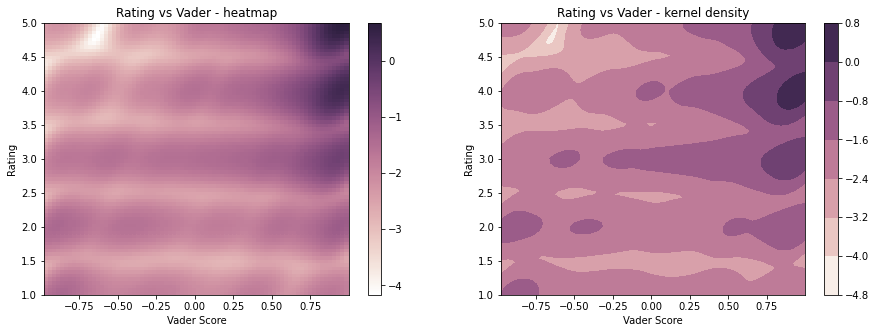

In [107]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))


b1 = ax1.pcolormesh(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)
b2 = ax2.contourf(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)

ax1.set_xlim(vader_scores.min(), vader_scores.max())
ax1.set_ylim(rating_scores.min(), rating_scores.max())
ax2.set_xlim(vader_scores.min(), vader_scores.max())
ax2.set_ylim(rating_scores.min(), rating_scores.max())

ax1.set_xlabel('Vader Score')
ax1.set_ylabel('Rating')

ax2.set_xlabel('Vader Score')
ax2.set_ylabel('Rating')

fig.colorbar(b1, ax=ax1)
fig.colorbar(b2, ax=ax2)

ax1.set_title('Rating vs Vader - heatmap')
ax2.set_title('Rating vs Vader - kernel density');

In [108]:
print("""  
This tells us that vader scores struggle to identify star ratings below 4.  
This also tells us that vader scores struggle to differentiate between star ratings  
- The hotspots for ratings 3,4,5 are all to the far right of the plot
- We would hope to see the hotspot for 4 further to the left for example

- We are concerned with density here
- For ratings of 5 on the y-axis we want to see high density to the right side of the plot
- For ratings of 1 we want to see high density on the left side of the plot
- We see accurate ratings for 5 however higher variance across the axis for 1

- Vader skews very highly towards high ratings and is better with positive sentiment than negative sentiment
- This may be due to the hypothesis stated earlier.  A review is unlikely to be entirely negative, and will often contain some positive feedback making it more difficult to detect
- We can also notice that there is a drop-off in accuracy after 5.  Ratings of 3 and 2 are especially difficult for vader
""")

  
This tells us that vader scores struggle to identify star ratings below 4.  
This also tells us that vader scores struggle to differentiate between star ratings  
- The hotspots for ratings 3,4,5 are all to the far right of the plot
- We would hope to see the hotspot for 4 further to the left for example

- We are concerned with density here
- For ratings of 5 on the y-axis we want to see high density to the right side of the plot
- For ratings of 1 we want to see high density on the left side of the plot
- We see accurate ratings for 5 however higher variance across the axis for 1

- Vader skews very highly towards high ratings and is better with positive sentiment than negative sentiment
- This may be due to the hypothesis stated earlier.  A review is unlikely to be entirely negative, and will often contain some positive feedback making it more difficult to detect
- We can also notice that there is a drop-off in accuracy after 5.  Ratings of 3 and 2 are especially difficult for va

In [109]:
# Show two scatterplots and two heatmaps of the length of reviews versus each of ground truth score and Vader sentiment score

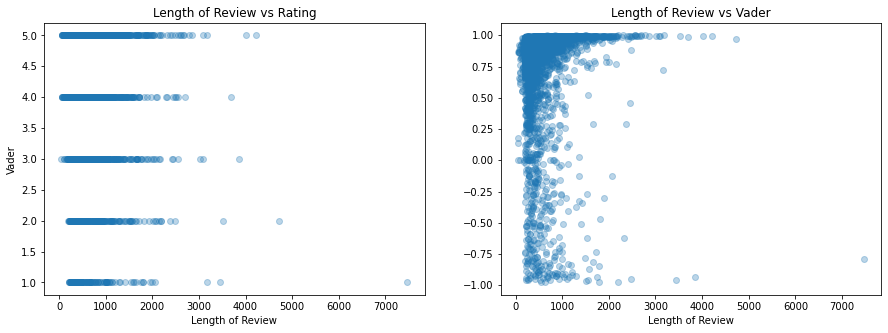

In [110]:
fig, ax = plt.subplots(1,2,figsize=(15,5),sharex=False,sharey=False)
rating_scores = finaldf['ratingScore'].values
vader_scores = finaldf['vader'].values
len_values = np.array([len(x) for x in finaldf['reviewCol'].values])
ax[0].plot(len_values, rating_scores,"o", alpha=0.3)
ax[1].plot(len_values, vader_scores,"o", alpha=0.3)

ax[0].set_title('Length of Review vs Rating')
ax[1].set_title('Length of Review vs Vader')
ax[0].set_ylabel('Rating')
ax[0].set_ylabel('Vader')
for _ax in ax:
  _ax.set_xlabel('Length of Review')

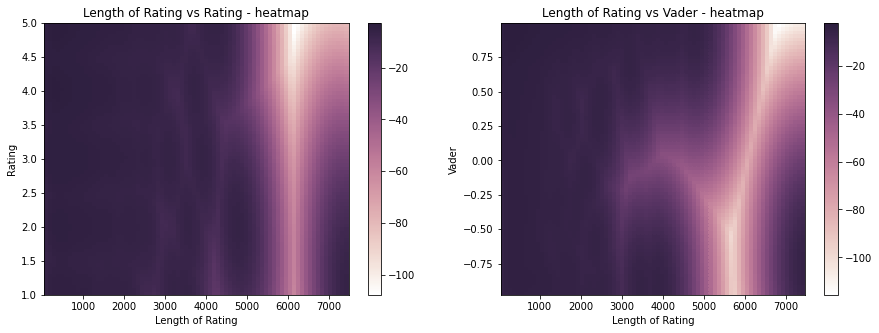

In [111]:
k1 = gaussian_kde(np.vstack([len_values, rating_scores]))
k2 = gaussian_kde(np.vstack([len_values, vader_scores]))
xi1, yi1 = np.mgrid[len_values.min():len_values.max():len_values.size**0.5*1j,rating_scores.min():rating_scores.max():rating_scores.size**0.5*1j]
xi2, yi2 = np.mgrid[len_values.min():len_values.max():len_values.size**0.5*1j,vader_scores.min():vader_scores.max():vader_scores.size**0.5*1j]
zi1 = k1(np.vstack([xi1.flatten(), yi1.flatten()]))
zi2 = k2(np.vstack([xi2.flatten(), yi2.flatten()]))

cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))


b1 = ax1.pcolormesh(xi1, yi1, np.log10(zi1.reshape(xi1.shape)), cmap=cmap)
b2 = ax2.pcolormesh(xi2, yi2, np.log10(zi2.reshape(xi2.shape)), cmap=cmap)

ax1.set_xlim(len_values.min(), len_values.max())
ax1.set_ylim(rating_scores.min(), rating_scores.max())
ax2.set_xlim(len_values.min(), len_values.max())
ax2.set_ylim(vader_scores.min(), vader_scores.max())

ax1.set_xlabel('Length of Rating')
ax1.set_ylabel('Rating')

ax2.set_xlabel('Length of Rating')
ax2.set_ylabel('Vader')

fig.colorbar(b1, ax=ax1)
fig.colorbar(b2, ax=ax2)

ax1.set_title('Length of Rating vs Rating - heatmap')
ax2.set_title('Length of Rating vs Vader - heatmap');

In [112]:
print("""
- Longer reviews are more likely to have a higher vader sentiment score.
- This could connect back to the hypothesis about negative reviews being hard to detect with vader, longer reviews may be even more likely to contain some degree of positive sentiment.
- There is no significant trend observed with ground truth scores.  Review length has little correlation with score.
""")


- Longer reviews are more likely to have a higher vader sentiment score.
- This could connect back to the hypothesis about negative reviews being hard to detect with vader, longer reviews may be even more likely to contain some degree of positive sentiment.
- There is no significant trend observed with ground truth scores.  Review length has little correlation with score.



In [113]:
# Show two scatterplots of the number of reviews per hotel versus each of average ground truth score and average Vader sentiment score. 

In [114]:
avg_rating = finaldf.groupby(by=['hotelName'])[['ratingScore']].mean()
avg_vader = finaldf.groupby(by=['hotelName'])[['vader']].mean()
avg_reviews = finaldf.groupby(by=['hotelName'])[['reviewCol']].count()

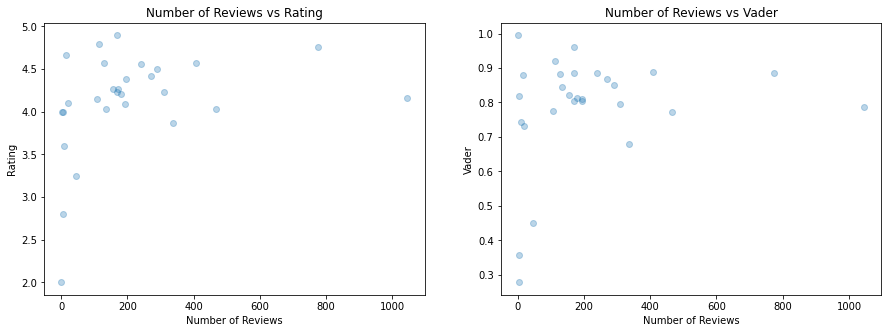

In [115]:
fig, ax = plt.subplots(1,2,figsize=(15,5),sharex=False,sharey=False)
rating_scores = avg_rating.values
vader_scores = avg_vader.values
n_reviews = avg_reviews.values
ax[0].plot(n_reviews, rating_scores,"o", alpha=0.3)
ax[1].plot(n_reviews, vader_scores,"o", alpha=0.3)

ax[0].set_title('Number of Reviews vs Rating')
ax[1].set_title('Number of Reviews vs Vader')
ax[0].set_ylabel('Rating')
ax[1].set_ylabel('Vader')
for _ax in ax:
  _ax.set_xlabel('Number of Reviews')

In [116]:
print("""
- Both ground truth and vader show similar trends
- Low rated hotels in both ground truth and vader will have a low number of reviews
- The hotels with the most reviews will have high ratings 
- There is no trend in-between these extremes
""")


- Both ground truth and vader show similar trends
- Low rated hotels in both ground truth and vader will have a low number of reviews
- The hotels with the most reviews will have high ratings 
- There is no trend in-between these extremes



In [117]:
def make_address(row):
  # individual columns need to be combined
  return row['streetAddress']+", "+row['City']+", "+row['Province']

In [118]:
def avg_rating_per_hotel(df):
  # average the scores over all hotels, you may need to provide additional filtering
  tempDf = df[['hotelName','vader','ratingScore','reviewCol']]
  tempDf.columns = ['hotelName','AverageVader', 'AverageRatingScore','n_reviews']
  tempDf = tempDf.groupby('hotelName').agg({'AverageVader':'mean', 'AverageRatingScore':'mean','n_reviews':'count'})
  return tempDf

In [119]:
avg_rating_df = avg_rating_per_hotel(finaldf)

In [120]:
# Need the location for each hotel in a format the tool can handle

geo_rating_df = avg_rating_df\
                         .join(hotelDF.groupby('hotelName')\
                         .agg({'streetAddress':'max','City':'max','Province':'max','postalCode':'max'}))
geo_rating_df['formed_address'] = geo_rating_df.apply(make_address , axis=1)
geo_rating_df.tail()

,AverageVader,AverageRatingScore,n_reviews,streetAddress,City,Province,postalCode,formed_address
hotelName,,,,,,,,
Ribbonwood Retreat Bed and Breakfast,0.959482,4.894118,170,26 Greens Road,Franz Josef,South Island,7856.0,"26 Greens Road, Franz Josef, South Island"
Scenic Hotel Franz Josef Glacier,0.771599,4.027837,467,36 Main Rd Off State Hwy 6,Franz Josef,South Island,7856.0,"36 Main Rd Off State Hwy 6, Franz Josef, South Island"
Te Waonui Forest Retreat,0.887034,4.568627,408,3 Wallace Street,Franz Josef,South Island,7856.0,"3 Wallace Street, Franz Josef, South Island"
The Terrace Motel,0.809137,4.379487,195,15 Cowan Street,Franz Josef,South Island,NaN,"15 Cowan Street, Franz Josef, South Island"
Westwood Lodge,0.882657,4.565891,129,Rapid Number 2919 State Highway 6,Franz Josef,South Island,7952.0,"Rapid Number 2919 State Highway 6, Franz Josef, South Island"


In [121]:
# 0 - need to give the tool a generic name.
locator = Nominatim(user_agent='myGeocoder')
# 1 - conveneint function to delay between geocoding calls
geocode = RateLimiter(locator.geocode, min_delay_seconds=1)
# 2 - form the location string
geo_rating_df['location'] = geo_rating_df['formed_address'].apply(geocode)
# 3 - create longitude, laatitude and altitude from location column (returns tuple)
geo_rating_df['point'] = geo_rating_df['location'].apply(lambda loc: tuple(loc.point) if loc else None)
# 4 - split point column into latitude, longitude and altitude columns
geo_rating_df[['latitude', 'longitude', 'altitude']] = pd.DataFrame(geo_rating_df['point'].tolist(), index=geo_rating_df.index)

geo_rating_df.head()

,AverageVader,AverageRatingScore,n_reviews,streetAddress,City,Province,postalCode,formed_address,location,point,latitude,longitude,altitude
hotelName,,,,,,,,,,,,,
10 Cottages,0.822897,4.264516,155,8 Graham Place,Franz Josef,South Island,7856.0,"8 Graham Place, Franz Josef, South Island","(8, Graham Place, Franz Josef / Waiau, Westland District, West Coast, 7856, New Zealand / Aotearoa, (-43.3870047, 170.1847372))","(-43.3870047, 170.1847372, 0.0)",-43.387005,170.184737,0.0
58 On Cron Motel,0.867409,4.422222,270,58 Cron Street,Franz Josef,South Island,7886.0,"58 Cron Street, Franz Josef, South Island","(58 on Cron, 58, Cron Street, Franz Josef / Waiau, Westland District, West Coast, 7952, New Zealand / Aotearoa, (-43.3848607, 170.1844537))","(-43.3848607, 170.1844537, 0.0)",-43.384861,170.184454,0.0
Alpine Escape,0.819480,4.000000,5,6 Ferguson Place,Franz Josef,South Island,7856.0,"6 Ferguson Place, Franz Josef, South Island",None,None,NaN,NaN,NaN
Alpine Glacier Motor Lodge,0.794877,4.232258,310,17 Cron Street,Franz Josef,South Island,NaN,"17 Cron Street, Franz Josef, South Island","(17, Cron Street, Franz Josef / Waiau, Westland District, West Coast, 7952, New Zealand / Aotearoa, (-43.3885702, 170.1831467))","(-43.3885702, 170.1831467, 0.0)",-43.388570,170.183147,0.0
Aspen Court Franz Josef,0.885141,4.760000,775,76 Cron Street,Franz Josef,South Island,7856.0,"76 Cron Street, Franz Josef, South Island","(76, Cron Street, Franz Josef / Waiau, Westland District, West Coast, 7952, New Zealand / Aotearoa, (-43.3839591, 170.1855716))","(-43.3839591, 170.1855716, 0.0)",-43.383959,170.185572,0.0


In [122]:
null_latlong = {
    'Alpine Escape':{'latitude':-43.3678078,'longitude':170.1927897}
    , 'Franz Alpine Retreat':{'latitude':-43.3626438,'longitude':170.2019584}
    , 'Franz Josef Montrose':{'latitude':-43.389494,'longitude':170.1810513}
    , 'Franz Josef Oasis':{'latitude':-43.358167,'longitude':170.1993153}
    , 'Glacier Cottages':{'latitude':-43.367337,'longitude':170.1835787}
    , 'Glacier Highway Motel':{'latitude':-43.3633488,'longitude':170.2021754}
    , 'Glacier View Motel':{'latitude':-43.3672829,'longitude':170.1835977}
    , 'Glenfern Villas':{'latitude':-43.3665817,'longitude':170.1915368}
    , 'Kahere Retreat':{'latitude':-43.3499071,'longitude':170.206419}
    , 'Ribbonwood Retreat Bed and Breakfast':{'latitude':-43.352159,'longitude':170.1986423}
    , 'Scenic Hotel Franz Josef Glacier':{'latitude':-43.3860881,'longitude':170.1801993}
    , 'Westwood Lodge':{'latitude':-43.3738889,'longitude':170.1794552}
}

In [123]:
geo_rating_df.loc[geo_rating_df.location.isna(),'latitude'] = geo_rating_df.loc[geo_rating_df.location.isna()].index.map({x:null_latlong[x]['latitude'] for x in null_latlong.keys()})
geo_rating_df.loc[geo_rating_df.location.isna(),'longitude'] = geo_rating_df.loc[geo_rating_df.location.isna()].index.map({x:null_latlong[x]['longitude'] for x in null_latlong.keys()})

In [124]:
map1 = folium.Map(
    location=[-43.375166,170.1774427], # <- this will need to be set based on your own hotels
    tiles='cartodbpositron',
    zoom_start=15,
)

geo_rating_df.apply(lambda row:folium.CircleMarker(location=[row["latitude"], row["longitude"]],popup=str(row["AverageRatingScore"]), color='#d7191c').add_to(map1), axis=1)

map1

In [125]:
import plotly.express as px

mapbox_access_token = 'pk.eyJ1IjoicHNwZWx0IiwiYSI6ImNqdW4xemNtYzB3ZDI0ZXM4Z2VkYWwwMTgifQ.UodsHknkt8fNv3Viszo1Zg'

px.set_mapbox_access_token(mapbox_access_token)
fig = px.scatter_mapbox(geo_rating_df,lat='latitude',lon='longitude',hover_data=['AverageRatingScore'],size='AverageRatingScore',color='AverageRatingScore',\
                        color_continuous_scale=px.colors.sequential.Blues,zoom=12,width=1000,height=1000)
fig.show()

In [138]:
# Using a sample of 6 hotels (2 highly rated, 2 lowly rated, and 2 mediocre) 
six_hotels = \
avg_rating_df[(avg_rating_df['n_reviews'] > 20)&(avg_rating_df['AverageRatingScore']>=4.5)].sample(n=2,random_state=99)\
.append(avg_rating_df[(avg_rating_df['n_reviews'] > 20)&(avg_rating_df['AverageRatingScore']>=4)&(avg_rating_df['AverageRatingScore']<4.5)].sample(n=2,random_state=99))\
.append(avg_rating_df[(avg_rating_df['n_reviews'] > 20)&(avg_rating_df['AverageRatingScore']<4)].sample(n=2,random_state=99))

In [139]:
# Plot the rolling average score as a function of time. 

In [140]:
q5e = hotelDF.copy()
q5e.loc[q5e.date_stamp=='today','date_stamp'] = 'November 16, 2020'
q5e.loc[q5e.date_stamp=='2 days ago','date_stamp'] = 'November 14, 2020'
q5e.loc[q5e.date_stamp=='3 days ago','date_stamp'] = 'November 13, 2020'
q5e.loc[q5e.date_stamp=='4 days ago','date_stamp'] = 'November 12, 2020'
q5e.loc[q5e.date_stamp=='6 days ago','date_stamp'] = 'November 10, 2020'
q5e.loc[q5e.date_stamp=='1 week ago','date_stamp'] = 'November 9, 2020'
q5e.loc[q5e.date_stamp=='2 weeks ago','date_stamp'] = 'November 2, 2020'
q5e.loc[q5e.date_stamp=='3 weeks ago','date_stamp'] = 'October 26, 2020'
q5e.loc[q5e.date_stamp=='4 weeks ago','date_stamp'] = 'October 19, 2020'
q5e.loc[q5e.date_stamp=='5 weeks ago','date_stamp'] = 'October 12, 2020'

In [141]:
q5e['date'] = pd.to_datetime(q5e.date_stamp)

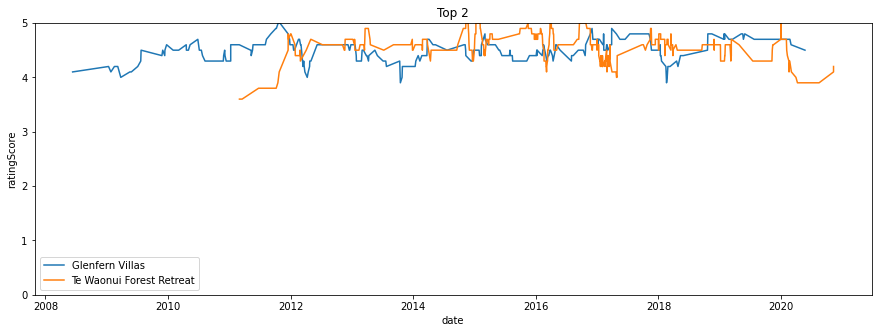

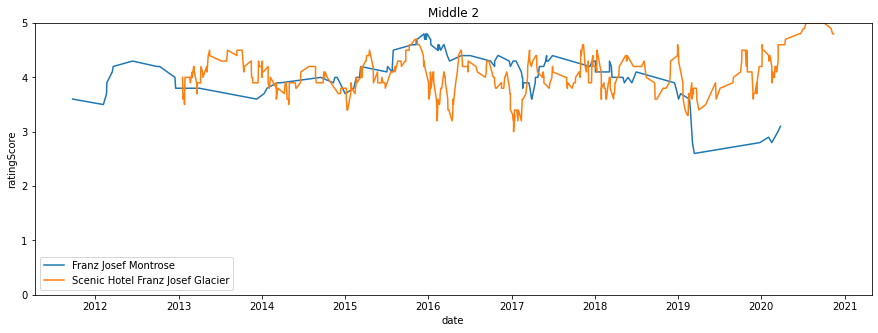

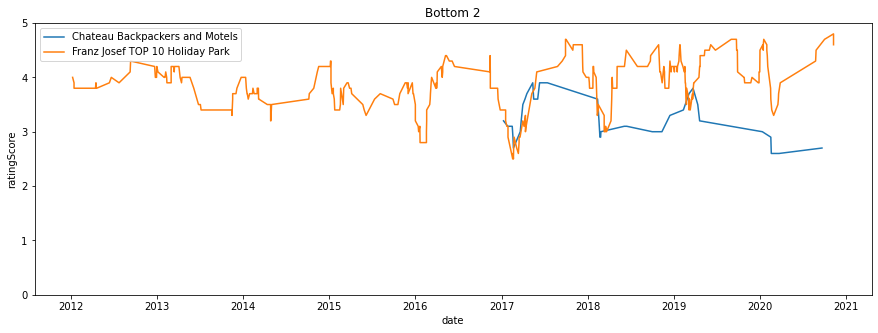

In [142]:
plt.figure(figsize=(15,5))
for h in six_hotels.index[:2]:
    df_ = q5e.loc[q5e.hotelName==h].sort_values(by='date').copy()
    df_['rolling'] = df_.ratingScore.rolling(10).mean()
    plt.plot(df_['date'],df_['rolling'])
plt.ylabel('ratingScore')
plt.xlabel('date')
plt.ylim(0,5)
plt.legend(six_hotels.index[:2])
plt.title("Top 2")
plt.show()

plt.figure(figsize=(15,5))
for h in six_hotels.index[2:4]:
    df_ = q5e.loc[q5e.hotelName==h].sort_values(by='date').copy()
    df_['rolling'] = df_.ratingScore.rolling(10).mean()
    plt.plot(df_['date'],df_['rolling'])
plt.ylabel('ratingScore')
plt.xlabel('date')
plt.ylim(0,5)
plt.legend(six_hotels.index[2:4])
plt.title("Middle 2")
plt.show()

plt.figure(figsize=(15,5))
for h in six_hotels.index[4:]:
    df_ = q5e.loc[q5e.hotelName==h].sort_values(by='date').copy()
    df_['rolling'] = df_.ratingScore.rolling(10).mean()
    plt.plot(df_['date'],df_['rolling'])
plt.ylabel('ratingScore')
plt.xlabel('date')
plt.ylim(0,5)
plt.legend(six_hotels.index[4:])
plt.title("Bottom 2")
plt.show()

In [143]:
print("""
- The top 2 hotels were fairly consistent with ratings between 4 and 5
- The middle 2 were less consistent with ratings down to 3 and up to 4.5 
- The bottom 2 were even less consistent with ratings fluctuating between 2.5 and 4.5
""")


- The top 2 hotels were fairly consistent with ratings between 4 and 5
- The middle 2 were less consistent with ratings down to 3 and up to 4.5 
- The bottom 2 were even less consistent with ratings fluctuating between 2.5 and 4.5



In [144]:
def time_range(q5e,hotels=[],start_end=None,period='1M'):
    """
    start_end: Tuple in the form ('2004-11-14','2019-12-12')
    period: '7d' for 7 days for example, or '1M' for 1 month
    """
    min_date = q5e.date.min()
    max_date = q5e.date.max()
    date_index = pd.DataFrame(pd.date_range(min_date,max_date),columns=['date'])
    hotel_index = q5e[['hotelName']].drop_duplicates().reset_index(drop=True)
    date_index.index = np.zeros(len(date_index))
    hotel_index.index = np.zeros(len(hotel_index))
    index = date_index.merge(hotel_index,how='left',left_index=True,right_index=True)
    df = index.merge(q5e[['date','hotelName','ratingScore']],how='left',on=['date','hotelName'])
    if start_end != None:
        df = df.loc[(df.date>=start_end[0])&(df.date<=start_end[1])].copy()
    plt.figure(figsize=(15,7.5))
    if len(hotels) == 0:
        hotel_list = list(q5e.hotelName.unique())
    else:
        hotel_list = hotels
    for h in hotel_list:
        df_ = df.loc[df.hotelName==h,['date','ratingScore']].groupby(pd.Grouper(key = 'date', freq=period)).count().reset_index()
        plt.plot(df_['date'],df_['ratingScore'])
    plt.title("Frequency of Reviews in " + period + " Time Periods")
    plt.ylabel('Number of Reviews')
    plt.xlabel('Date')
    plt.legend(hotel_list)
    plt.show()

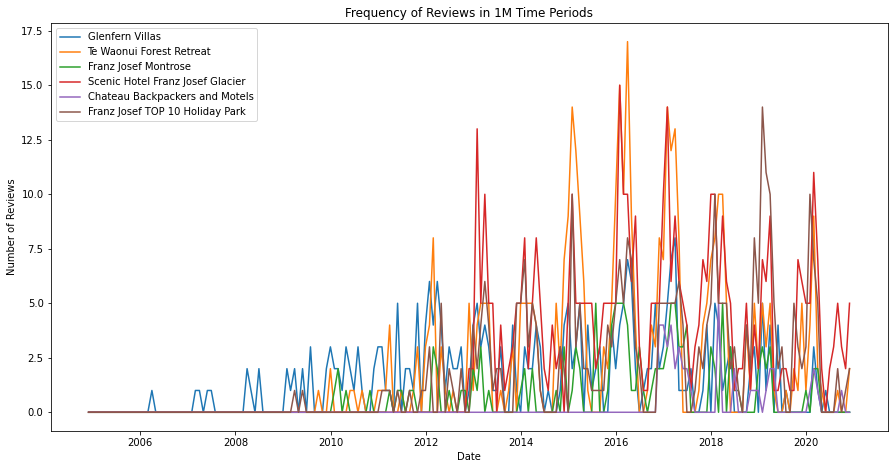

In [145]:
# Can plot all hotels over entire time frame
time_range(q5e,hotels=list(six_hotels.index))

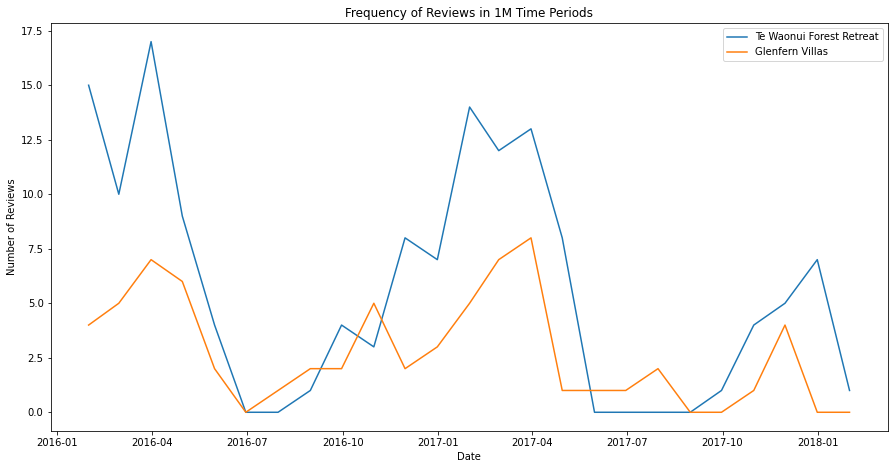

In [146]:
time_range(q5e,hotels=['Te Waonui Forest Retreat','Glenfern Villas'],start_end=('2016-01-01','2018-01-01'))

In [147]:
print("""
- The hotels tend to peak at the same time, my hypothesis is that this is driven by ebbs and flows in the tourist season
- In the example time period 2016 to 2018 we observe the peak season beginning around November and ending around April

This suggests we have seasonal trends in the spring and late winter.  
In the southern hemisphere this lines up with summer and late summer season which we can presume is the peak tourist time for New Zealand.
""")


- The hotels tend to peak at the same time, my hypothesis is that this is driven by ebbs and flows in the tourist season
- In the example time period 2016 to 2018 we observe the peak season beginning around November and ending around April

This suggests we have seasonal trends in the spring and late winter.  
In the southern hemisphere this lines up with summer and late summer season which we can presume is the peak tourist time for New Zealand.

